In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
from pylamp.neural.layers import Linear
from pylamp.neural.activations import Sigmoid, TanH, ReLU
from pylamp.optim.optimizer import SGD
from pylamp.loss.losses import BCELoss, MSELoss
from pylamp.utils.data import DataGenerator as dg 

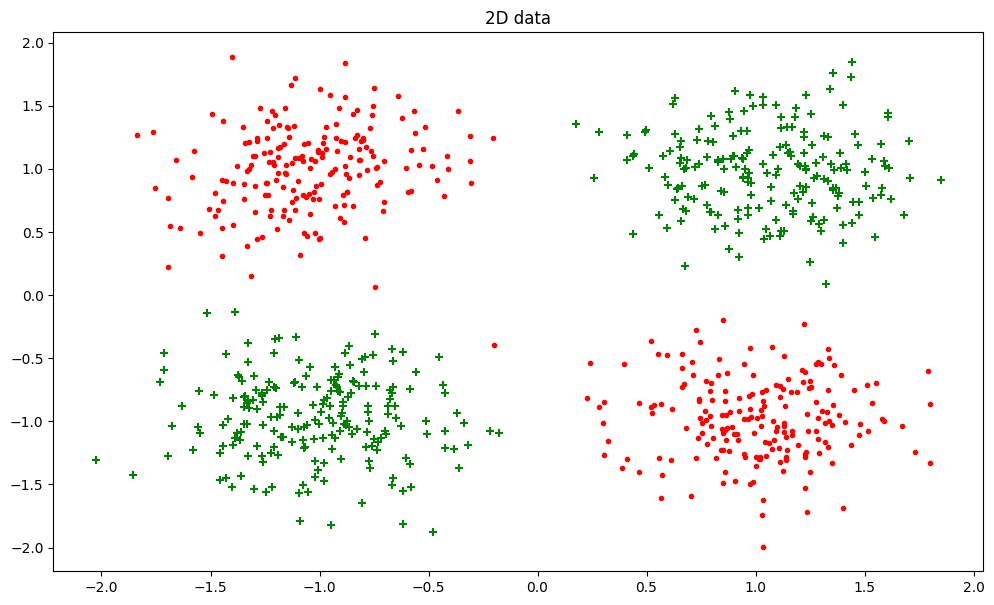

In [95]:
X_train, X_test, y_train, y_test  = dg.generate_2D_data(data_type=1, epsilon=0.1)
dg.plot_2D_data(X_train, y_train)

In [96]:
input_size = X_train.shape[1]
hidden_size = 8
output_size = y_train.shape[1]

print(f'input_size: {input_size}, output_size: {output_size}')

fc1 = Linear(input_size, hidden_size, use_bias=True)
fc2 = Linear(hidden_size, output_size, use_bias=True)
tanh = ReLU()
sigmoid = Sigmoid()


loss = MSELoss()
train_loss = SGD.step_multiple(
    fc1,fc2,tanh,sigmoid, loss, X_train=X_train, y_train=y_train, 
    epochs=200, lr=1e-3, batch_size=8, verbose=True,
)

input_size: 2, output_size: 1
Epoch 0 : Train loss : 14.121467874530177
Epoch 20 : Train loss : 10.882243456192514
Epoch 40 : Train loss : 9.976715967322114
Epoch 60 : Train loss : 8.964545661308083
Epoch 80 : Train loss : 8.053704960552526
Epoch 100 : Train loss : 7.548572283350276
Epoch 120 : Train loss : 7.24661508775292
Epoch 140 : Train loss : 7.04885808242124
Epoch 160 : Train loss : 6.909524827784709
Epoch 180 : Train loss : 6.806358940188635
Model updated 20000 times.


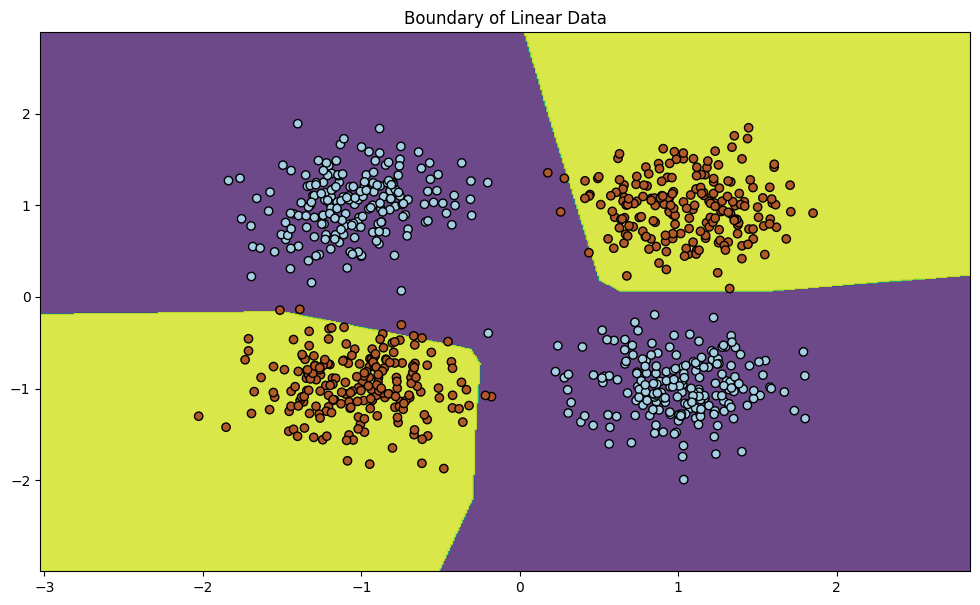

In [97]:
class ModelTest():
    def __init__(self, models) -> None:
        self.models = models
    
    def forward(self,X):
        output = X 
        for model in self.models:
            output = model.forward(output)
        return output

model = ModelTest([fc1,tanh,fc2,sigmoid])
dg.plot_decision_boundary(X_train, y_train, model, "Boundary of Linear Data")